


# Disorder Classification with Random Forest Classifier


In [88]:
# Import Requirements
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTEENN

In [96]:
# Data Loading & Preprocessing
EEG = pd.read_csv('Train_and_Validate_EEG.csv')
EEG['sex'] = EEG['sex'].map({'M': 1, 'F': 0})
EEG['education'].fillna(EEG['education'].mean(), inplace=True)
EEG['IQ'].fillna(EEG['IQ'].mean(), inplace=True)

<ipython-input-96-cfa47494d472>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  EEG['education'].fillna(EEG['education'].mean(), inplace=True)
<ipython-input-96-cfa47494d472>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [97]:
# Drop unneeded columns, split input & output
X = EEG.drop(['main.disorder',
              'ID',
              'specific.disorder',
              'eeg.date',
              'Unnamed: 122',
              # 'education',
              # 'IQ',
              ], axis=1)
y = EEG['main.disorder']

# Use smote_tomek to balance (resample) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
smote_tomek = SMOTETomek()
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

In [107]:
# train a random forest model
rf_model = RandomForestClassifier(
    max_features='sqrt',
    n_estimators=100,
    random_state=50,
    max_depth=20,
    max_samples=0.8,
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Record feature importance for future use
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

Accuracy: 0.2305


Top 100 features -> Accuracy: 0.2344
Top 150 features -> Accuracy: 0.2266
Top 200 features -> Accuracy: 0.1992
Top 250 features -> Accuracy: 0.2461
Top 300 features -> Accuracy: 0.2148
Top 350 features -> Accuracy: 0.2617
Top 400 features -> Accuracy: 0.2344
Top 450 features -> Accuracy: 0.2422
Top 500 features -> Accuracy: 0.2383
Top 550 features -> Accuracy: 0.2461
Top 600 features -> Accuracy: 0.2383
Top 650 features -> Accuracy: 0.2148
Top 700 features -> Accuracy: 0.2383
Top 750 features -> Accuracy: 0.2070
Top 800 features -> Accuracy: 0.2227
Top 850 features -> Accuracy: 0.2070
Top 900 features -> Accuracy: 0.2539
Top 950 features -> Accuracy: 0.2188


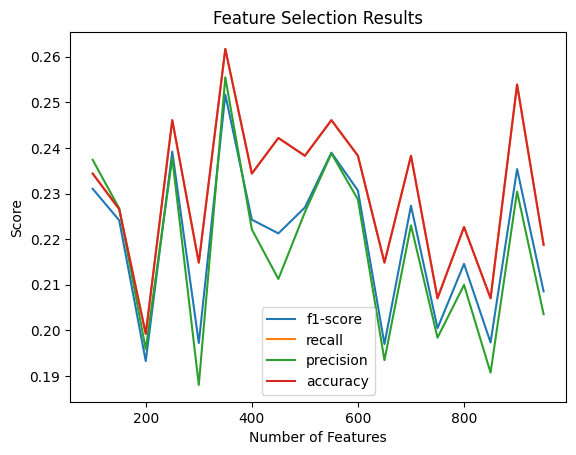

=== Best Model Classification Report ===
                                    precision    recall  f1-score   support

                Addictive disorder       0.24      0.37      0.29        51
                  Anxiety disorder       0.04      0.04      0.04        27
                   Healthy control       0.21      0.27      0.24        26
                     Mood disorder       0.40      0.40      0.40        75
     Obsessive compulsive disorder       0.00      0.00      0.00        12
                     Schizophrenia       0.24      0.18      0.21        33
Trauma and stress related disorder       0.27      0.12      0.17        32

                          accuracy                           0.26       256
                         macro avg       0.20      0.20      0.19       256
                      weighted avg       0.26      0.26      0.25       256



In [133]:
f1_scores = []
recalls = []
precisions = []
accuracies = []

highest_accuracy = 0.0
best_model = None
best_features = None

for top in range(100, 1000, 50):
    # Get top-N features
    selected_features = list(feature_importances.index[:top])
    X_train_selected = X_train[selected_features]
    X_test_selected  = X_test[selected_features]

    # Train the RF model
    model = RandomForestClassifier(
        max_features='sqrt',
        max_depth=10,
        n_estimators=100,
    )
    model.fit(X_train_selected, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    f1_val       = report_dict['weighted avg']['f1-score']
    recall_val   = report_dict['weighted avg']['recall']
    precision_val= report_dict['weighted avg']['precision']

    f1_scores.append(f1_val)
    recalls.append(recall_val)
    precisions.append(precision_val)
    accuracies.append(accuracy)

    print(f"Top {top} features -> Accuracy: {accuracy:.4f}")

    # Update "best" if this model’s accuracy is higher
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_model = model
        best_features = selected_features

# Plot the Metrics & Selction history
feature_counts = list(range(100, 1000, 50))
plt.plot(feature_counts, f1_scores, label='f1-score')
plt.plot(feature_counts, recalls,   label='recall')
plt.plot(feature_counts, precisions,label='precision')
plt.plot(feature_counts, accuracies,label='accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Feature Selection Results')
plt.legend()
plt.show()

# Classification Report for the best model
X_test_best = X_test[best_features]
y_pred_best = best_model.predict(X_test_best)
print("=== Best Model Classification Report ===")
print(classification_report(y_test, y_pred_best))

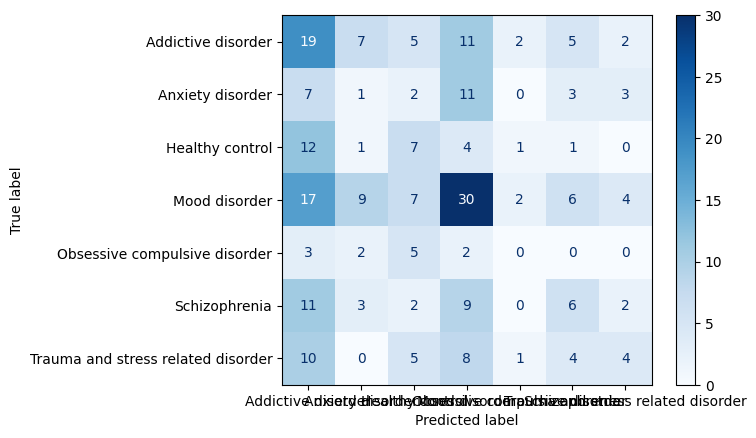

In [135]:
# plot the confusion matrix of best_model
labels = best_model.classes_
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")

In [136]:
EEG_test = pd.read_csv('Test_Set_EEG.csv')
EEG_test['sex'] = EEG_test['sex'].map({'M': 1, 'F': 0})
EEG_test['education'].fillna(EEG_test['education'].mean(), inplace=True)
EEG_test['IQ'].fillna(EEG_test['IQ'].mean(), inplace=True)

<ipython-input-136-79c3de0443b2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  EEG_test['education'].fillna(EEG_test['education'].mean(), inplace=True)
<ipython-input-136-79c3de0443b2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [138]:
# predict EEG_test with the best model
X_test_best = EEG_test[best_features]
y_pred_best = best_model.predict(X_test_best)
# export to csv
submission = pd.DataFrame({'ID': EEG_test['ID'], 'main.disorder.class': y_pred_best})
submission.to_csv('submission.csv', index=False)